# 0. Setting Up The Env

## 0.1 Packages

In [1]:
from pathlib import Path

In [2]:
import pandas as pd 
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [4]:
from scipy.stats import chi2_contingency

## 0.2 Utilities

In [5]:
def cramers_v(x, y):
    """
    Calculate Cramér's V statistic 
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, exp = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))), chi2, p

def association_with_target(df, x_list, y):
    """
    Test association between target categorical variable y and categorical features in x_list.
    """
    results = []
    for col in x_list:
        v, chi2, p = cramers_v(df[col], df[y])
        results.append({
            "Feature": col,
            "Target": y,
            "Cramer's V": round(v, 3),
            "Chi2 Statistic": round(chi2, 3),
            "p-value": round(p, 5),
            "Significance": "Significant" if p < 0.05 else "Not Significant"
        })
    return pd.DataFrame(results)

## 0.3 Constants

In [6]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [7]:
raw_file_path = f"{project_root}/data/raw/bank-additional.csv"
raw_file_path

'd:\\01 Work\\06-Segmentations/data/raw/bank-additional.csv'

# 1. The Data

In [8]:
data_df  = pd.read_csv(raw_file_path, sep=";")
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 4119 rows and 21 columns
Data Preview:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


# 2. Data Check

In [9]:
print(data_df.isnull().sum())




age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

## 2.1 Target Var

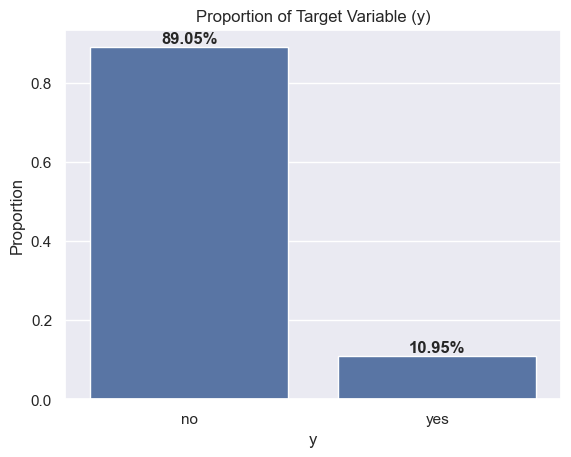

In [11]:
ax = sns.barplot(
    x=data_df['y'].value_counts(normalize=True).index,
    y=data_df['y'].value_counts(normalize=True).values,
)

# Add percentage labels
for i, v in enumerate(data_df['y'].value_counts(normalize=True).values):
    ax.text(i, v + 0.01, f"{v:.2%}", ha="center", fontweight="bold")

ax.set_title("Proportion of Target Variable (y)")
ax.set_xlabel("y")
ax.set_ylabel("Proportion")
plt.show()

## 2.2 Numeric Columns

In [12]:
data_df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,4119.0,40.113620,10.313362,18.000,32.000,38.000,47.000,88.000
duration,4119.0,256.788055,254.703736,0.000,103.000,181.000,317.000,3643.000
campaign,4119.0,2.537266,2.568159,1.000,1.000,2.000,3.000,35.000
pdays,4119.0,960.422190,191.922786,0.000,999.000,999.000,999.000,999.000
previous,4119.0,0.190337,0.541788,0.000,0.000,0.000,0.000,6.000
emp.var.rate,4119.0,0.084972,1.563114,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,4119.0,93.579704,0.579349,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,4119.0,-40.499102,4.594578,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,4119.0,3.621356,1.733591,0.635,1.334,4.857,4.961,5.045
nr.employed,4119.0,5166.481695,73.667904,4963.600,5099.100,5191.000,5228.100,5228.100


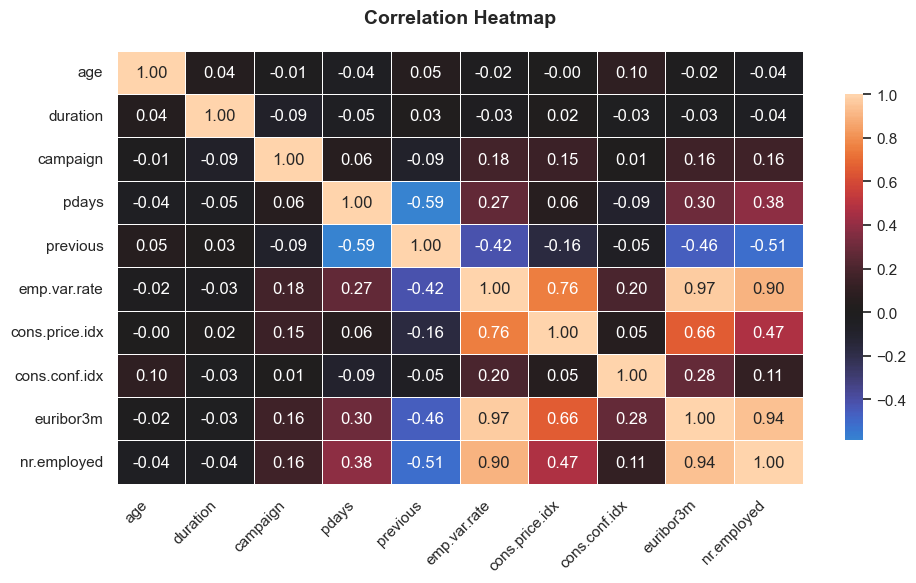

In [13]:
plt.figure(figsize=(10, 6))
corr = data_df.corr(numeric_only=True)

ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # add grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

* High Correlations :
* Other than that, strong correlations between anything, other than **pdays**(*number of days that passed by after the client was last contacted from a previous campaign*) and **previous**(*number of contacts performed before this campaign and for this client*) which shows medium correlationship

## 2.3 Categorical Columns

In [14]:
data_df.describe(include=['O']).T

,count,unique,top,freq
job,4119,12,admin.,1012
marital,4119,4,married,2509
education,4119,8,university.degree,1264
default,4119,3,no,3315
housing,4119,3,yes,2175
loan,4119,3,no,3349
contact,4119,2,cellular,2652
month,4119,10,may,1378
day_of_week,4119,5,thu,860
poutcome,4119,3,nonexistent,3523


In [15]:
for col in data_df.select_dtypes(include="object"):
    print( data_df[col].value_counts(normalize=True))
    print("*"*100)

job
admin.           0.245691
blue-collar      0.214615
technician       0.167759
services         0.095412
management       0.078660
retired          0.040301
self-employed    0.038602
entrepreneur     0.035931
unemployed       0.026948
housemaid        0.026706
student          0.019908
unknown          0.009468
Name: proportion, dtype: float64
****************************************************************************************************
marital
married     0.609128
single      0.279922
divorced    0.108279
unknown     0.002671
Name: proportion, dtype: float64
****************************************************************************************************
education
university.degree      0.306871
high.school            0.223598
basic.9y               0.139354
professional.course    0.129886
basic.4y               0.104151
basic.6y               0.055353
unknown                0.040544
illiterate             0.000243
Name: proportion, dtype: float64
*************************

* **Month** Can be converted to periodic for numeric calculations
* *Binary Columns* can also be converted for easier calculations

# 3. Association Tests

In [16]:
object_cols = data_df.select_dtypes(include=["object"]).columns.tolist()
object_cols = object_cols[:-1]
print(len(object_cols))

10


In [17]:
insight_table = association_with_target(data_df, object_cols, "y")
print(insight_table)

       Feature Target  Cramer's V  Chi2 Statistic  p-value     Significance
0          job      y       0.120          69.979  0.00000      Significant
1      marital      y       0.042          10.286  0.01629      Significant
2    education      y       0.061          22.292  0.00226      Significant
3      default      y       0.073          24.186  0.00001      Significant
4      housing      y       0.000           0.627  0.73074  Not Significant
5         loan      y       0.000           1.130  0.56845  Not Significant
6      contact      y       0.136          76.846  0.00000      Significant
7        month      y       0.266         299.788  0.00000      Significant
8  day_of_week      y       0.000           0.512  0.97230  Not Significant
9     poutcome      y       0.331         454.487  0.00000      Significant


# END